In [24]:
from __future__ import division
import csv
import numpy as np
import sys
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import pandas as pd
import scipy.optimize as so


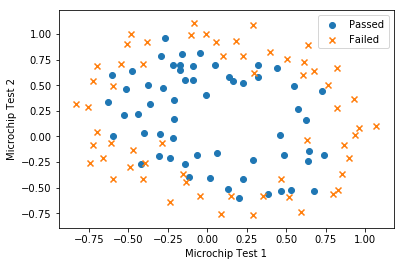

In [25]:
# Load data
df = pd.read_csv('datasets/ex2data2.csv')

X = np.array((df.Test_1.to_numpy(), df.Test_2.to_numpy()))

yes_indices = np.where((df.Pass) == 1)[0]
no_indices = np.where((df.Pass) == 0)[0]

df_yes = df.drop(no_indices)
df_no = df.drop(yes_indices)
assert len(df_yes) + len(df_no) == len(df)
y = np.array(df.Pass)
number_of_samples = len(y)

# Plot data
plt.figure(100)
plt.scatter(df_yes.Test_1, df_yes.Test_2, marker='o', label='Passed')
plt.scatter(df_no.Test_1, df_no.Test_2, marker='x', label='Failed')
plt.xlabel('Microchip Test 1')
plt.ylabel('Microchip Test 2')
plt.legend()
plt.show()

In [26]:

def sigmoid(z):

    sig = 1/(1 + np.exp(-z))
    return sig
    
def construct_matrix_with_mapped_features(X : np.ndarray, degree) -> np.ndarray:
    '''

    :param X: feature matrix
    :param degree : highest order of the polynomial
    :return: higher dimension feature matrix X_out
    '''

    X_out = np.ones((1, len(X[1])))

    for i in range(1, degree + 1, 1):
        for j in range(0, i + 1, 1):
            X_out = np.vstack((X_out, pow(X[0], (i - j)) * pow(X[1], j)))

    return X_out


def compute_cost_with_regularization(theta : np.ndarray, X : np.ndarray , y:np.ndarray, lambda_for_regularization :float) -> float:
    '''

    :param theta: np.array with Mx1 dimension
    :param X: np.array MxN dimension
    :param y: np.array with 1xN dimension
    :param lambda_for_regularization : float
    :return: cost J_theta
    '''
    theta_for_regularization = theta[1:]
    J_theta = np.mean(-y * np.log(sigmoid(theta.transpose().dot(X))) -
                      (1-y) * np.log(1 - sigmoid(theta.transpose().dot(X)))) \
                       + lambda_for_regularization/(2*len(y)) * np.sum(theta_for_regularization**2)

    return J_theta

def minimize_cost_and_find_theta_with_regularization(initial_theta: np.ndarray, X :np.ndarray, y:np.ndarray, lambda_for_regularization) -> tuple():
    '''
       :param initial_theta: np.array with Mx1 dimension
       :param X: np.array MxN dimension
       :param y: np.array with 1xN dimension
       :param lambda_for_regularization
       :return: optimized parameters thetas
    '''

    # Advanced minimizing algorithm
    result = so.minimize(fun =compute_cost_with_regularization,
                         x0 =initial_theta,
                         args = (X,y, lambda_for_regularization),
                         jac = compute_gradients_with_regularization)
    '''
    fun : function to minimize, in this case it is compute_cost 
    x0 : initial value of the variable to be optimized for minimum cost 
    args : additional arguments to the compute_cost function 
    jac : function to calculate the gradient 
    '''
    return result

def plot_decision_boundary_contours(theta : np.ndarray,
                                    X: np.ndarray,
                                    y:np.ndarray,
                                    fig_number : int,
                                    color :str) -> plt.figure:
    '''
        :param initial_theta: np.array with Mx1 dimension
        :param X: np.array MxN dimension
        :param y: np.array with 1xN dimension
        :param fig_number
        :return: figure object
    '''

    features_min = X.min(axis = 1)
    features_max = X.max(axis = 1)

    u = np.linspace(features_min[0] ,features_max[0], 50)
    v = np.linspace(features_min[0], features_max[0], 50)

    z = np.zeros((len(u), len(v)))

    for i, val_u in enumerate(u):
        for j, val_v in enumerate(v):
            input_feature_matrix = np.vstack((val_u, val_v))
            input_mapped_feature_matrix = construct_matrix_with_mapped_features(input_feature_matrix, degree = 6)
            z[i,j] = input_mapped_feature_matrix.transpose().dot(theta)

    fig  = plt.figure(fig_number)
    cntr = plt.contour(u, v, z.transpose(), levels = 0, colors = color)
    return cntr


def predict_outcome_for_given_dataset(theta: np.ndarray, X : np.ndarray) -> np.ndarray:
    '''

    :param theta: np.array with Mx1 dimension
    :param X: np.array MxN dimension
    :return: prediction for the dataset
    '''
    probability = sigmoid(X.transpose().dot(theta))
    prediction = (probability > 0.5).astype(int)

    return prediction

def get_accuracy(prediction : np.ndarray, y: np.ndarray) -> float:
    '''

    :param prediction: predicted vector from optimization
    :param y: actual output
    :return: accuracy
    '''
    accuracy = len(np.where((prediction == y))[0]) / len(y) * 100.0
    return accuracy



def compute_gradients_with_regularization(theta : np.ndarray, X : np.ndarray , y:np.ndarray, lambda_for_regularization :float) -> np.ndarray:
    '''

        :param theta: np.array with Mx1 dimension
        :param X: np.array MxN dimension
        :param y: np.array with 1xN dimension
        :return: gradients
        '''


    gradients = (sigmoid(theta.transpose().dot(X)) - y).dot(X.transpose())/len(y)
    for index, theta_val in enumerate(theta):
        if index > 0 :
            gradients[index] = gradients[index] + lambda_for_regularization/len(y) * theta_val
    return gradients



In [27]:
# Looking at the data tells us that the data can not be separated using a line. It requires some other kind of decision boundary.
# One way to fit the data is using more features, and create a polynom with the features.
# We need to make a base function matrix, which is called mapping the features to several of its instances.
# Let us create this mapfeature matrix, what I would also call the base matrix

X_with_mapped_features = construct_matrix_with_mapped_features(X, degree=6)

initial_theta = np.zeros(X_with_mapped_features.shape[0])
cost = compute_cost_with_regularization(initial_theta, X_with_mapped_features, y,
                                                           lambda_for_regularization=1)
gradients = compute_gradients_with_regularization(initial_theta, X_with_mapped_features, y,
                                                                     lambda_for_regularization=1)
print(f'Cost at initial theta : {cost}')
print(f'Gradients at initial theta: {gradients}')

# Perform optimization on cost_function to find optimized theta
result = minimize_cost_and_find_theta_with_regularization(initial_theta,
                                                                             X_with_mapped_features,
                                                                             y, lambda_for_regularization=1)
final_theta = result.x
print(f'Final cost at optimized thetas: {result.fun}')
print(f'Optimized thetas: {result.x}')


Cost at initial theta : 0.6931471805599454
Gradients at initial theta: [8.47457627e-03 1.87880932e-02 7.77711864e-05 5.03446395e-02
 1.15013308e-02 3.76648474e-02 1.83559872e-02 7.32393391e-03
 8.19244468e-03 2.34764889e-02 3.93486234e-02 2.23923907e-03
 1.28600503e-02 3.09593720e-03 3.93028171e-02 1.99707467e-02
 4.32983232e-03 3.38643902e-03 5.83822078e-03 4.47629067e-03
 3.10079849e-02 3.10312442e-02 1.09740238e-03 6.31570797e-03
 4.08503006e-04 7.26504316e-03 1.37646175e-03 3.87936363e-02]
Final cost at optimized thetas: 0.5290027422869217
Optimized thetas: [ 1.27268739  0.62557016  1.1809665  -2.01919822 -0.91761468 -1.43194199
  0.12375921 -0.36513086 -0.35703388 -0.17485805 -1.45843772 -0.05129676
 -0.61603963 -0.2746414  -1.19282569 -0.24270336 -0.20570022 -0.04499768
 -0.27782709 -0.29525851 -0.45613294 -1.04377851  0.02762813 -0.29265642
  0.01543393 -0.32759318 -0.14389199 -0.92460119]


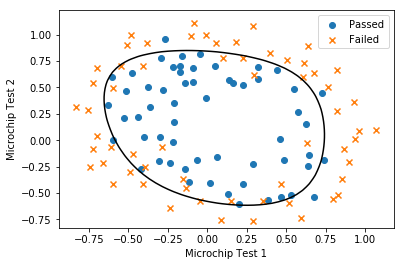

Accuracy of clissification model is 83.05084745762711 %


In [28]:
# Plot decision boundary
# Plot data
plt.figure(1)
plt.scatter(df_yes.Test_1, df_yes.Test_2, marker='o', label='Passed')
plt.scatter(df_no.Test_1, df_no.Test_2, marker='x', label='Failed')
plt.xlabel('Microchip Test 1')
plt.ylabel('Microchip Test 2')
plt.legend()

plot_with_decision_boundary = plot_decision_boundary_contours(final_theta, X, y, 1, color='k')
plt.show()

# Calculate accuracy on predicted results
prediction_on_training_data_set = predict_outcome_for_given_dataset(final_theta,
                                                                                       X_with_mapped_features)
accuracy = get_accuracy(prediction_on_training_data_set, y)
print(f'Accuracy of clissification model is {accuracy} %')

Accuracy on the training set for lambda = 0 is 91.52542372881356
Accuracy on the training set for lambda = 1 is 83.05084745762711
Accuracy on the training set for lambda = 10 is 74.57627118644068
Accuracy on the training set for lambda = 100 is 61.016949152542374


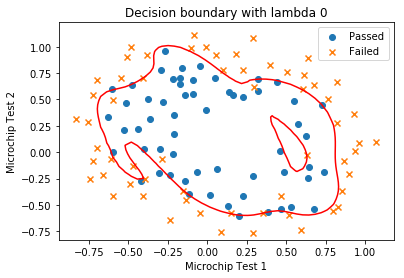

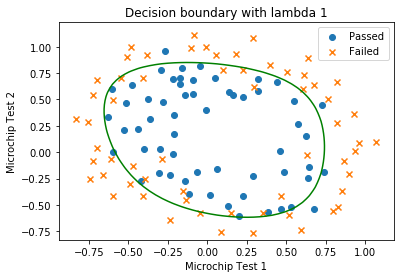

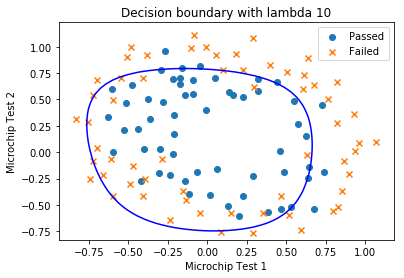

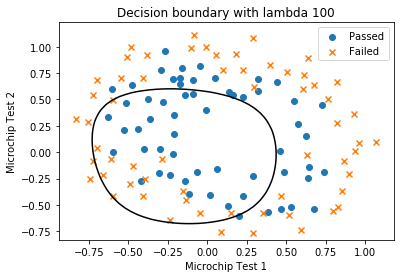

In [29]:
# Running optimization routine for different values of theta
lambda_for_regularization_list = [0, 1, 10, 100]
labels = [str(lambda_for_regularization_list_i) for lambda_for_regularization_list_i in lambda_for_regularization_list]
colors = ['r', 'g', 'b', 'k']
h = []

for index, lambda_i in enumerate(lambda_for_regularization_list):
    # Plot data
    plt.figure(index)
    plt.scatter(df_yes.Test_1, df_yes.Test_2, marker='o', label='Passed')
    plt.scatter(df_no.Test_1, df_no.Test_2, marker='x', label='Failed')
    plt.xlabel('Microchip Test 1')
    plt.ylabel('Microchip Test 2')
    plt.legend()

    initial_theta = np.zeros(X_with_mapped_features.shape[0])
    cost = compute_cost_with_regularization(initial_theta, X_with_mapped_features, y, lambda_i)
    gradients = compute_gradients_with_regularization(initial_theta, X_with_mapped_features, y,
                                                                         lambda_i)
    result = minimize_cost_and_find_theta_with_regularization(initial_theta, X_with_mapped_features,
                                                                                 y, lambda_i)
    final_theta = result.x
    prediction_on_training_data_set = predict_outcome_for_given_dataset(final_theta,
                                                                                           X_with_mapped_features)
    accuracy = get_accuracy(prediction_on_training_data_set, y)
    print(f'Accuracy on the training set for lambda = {lambda_i} is {accuracy}')

    plot_with_decision_boundary = plot_decision_boundary_contours(final_theta, X, y, index, colors[index])
    plt.title(f'Decision boundary with lambda {lambda_i}')

plt.show()